# ANUNCIOS

### En el módulo 3 no se evaluará exámen ni proyecto por falta de tiempo. Las clases que se alcancen a ver se asignarán tareas.

### Por lo tanto el 50% de la evaluación del curso se distribuirá en los proyectos del módulo 1 y 2 (25% cada uno) y el 30% de los exámenes también se distribuirá (15% cada uno)

## Exámen del módulo 2: clase de repaso Lunes 27 de Abril. Ese día les entrego el exámen y tendrán hasta el Miércoles 29 de Abril de 2020 a las 8:55 para entregarlo.

## Presentación del proyecto módulo 2: 6 de Mayo de 2020 en la hora de clase. Cada equipo tendrá máximo 10 minutos para presentar. Se hará la presentación por el mismo medio que se han dictado las clases (video conferencia por Webex). 

### - Todos los integrantes del equipo beben hablar y se pondrán de acuerdo en qué momento le toca hablar a cada quién. 

### - La restricción de máximo 10 minutos por cada equipo tiene cero tolerancia, es decir se cortará la presentación a los 10 minutos.

### - A más tardar el día de hoy deben enviar los nombres con los integrantes del equipo al correo electrónico. El equipo que no envíe el correo, no tendrá derecho a presentar el proyecto.

# Aplicando Python para análisis de precios: simulación de escenarios futuros de precios

<img style="float: right; margin: 0px 0px 15px 15px;" src="https://upload.wikimedia.org/wikipedia/commons/d/d7/Philippine-stock-market-board.jpg" width="400px" height="125px" />

> En la clase anterior vimos como importar datos de activos de la base de datos de Yahoo Finance usando el paquete pandas-datareader. En esta clase, veremos como pronosticar escenarios de evolución de precios, suponiendo que los rendimientos diarios se distribuyen normalmente. Como esta evolución de precios es aleatoria, utilizaremos la simulación montecarlo (hacer muchas simulaciones de escenarios de evolución de precios) para obtener probabilidades de que los precios de cierre estén encima de un valor umbral y tomar decisiones con base en estas probabilidades.

**Referencias:**
- http://pandas.pydata.org/
- http://www.learndatasci.com/python-finance-part-yahoo-finance-api-pandas-matplotlib/

## 1. Recordemos como descargar datos...

Antes que nada, para poder hacer simular escenarios de predicción de precios, vamos a recordar lo que hicimos en la clase pasada de descargar los datos de Yahoo Finance, utilizando el paquete `data` de la librería `pandas_datareader`.

Esta vez, utilizaremos los datos de precios de cierre ajustados de activos de la compañía Apple en el año 2016 para nuestra aplicación.

In [1]:
# Importamos librerías
import pandas as pd
import pandas_datareader as web
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
# Función para descargar precios de cierre ajustados de varios activos a la vez:
def get_closes(names,start,end):
    closes = web.DataReader(names,"yahoo",start,end)
    return closes["Adj Close"]

In [3]:
# Descargamos datos...
# Instrumento: Amazon
names = ["AMZN"]

# Fechas de interés (inicio y fin): 2014-2018
start = '2014-01-01'
end = '2018-12-31'

# Función DataReader
closes_AMZN = get_closes(names,start,end)

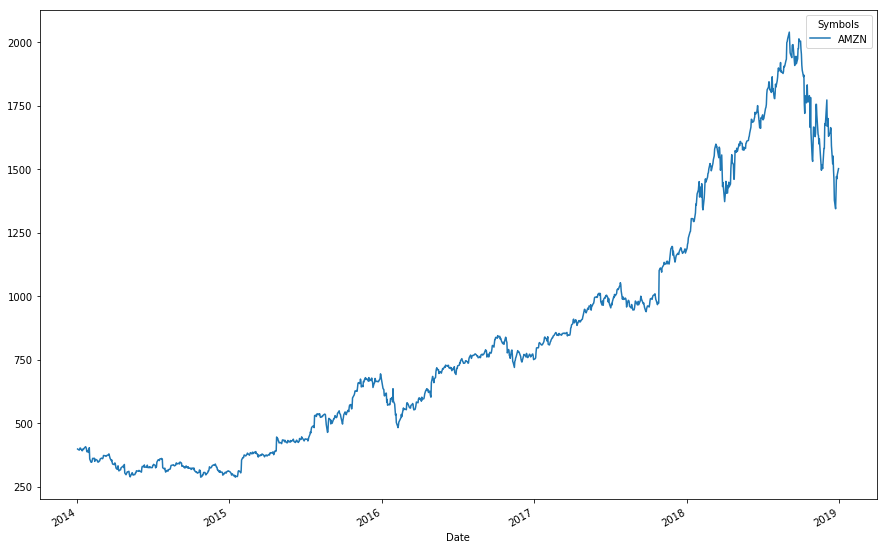

In [4]:
# Graficamos
closes_AMZN.plot(figsize=(15,10))

## 2. Simulación de rendimientos diarios

Recordemos que los precios diarios de cierre ajustados no son un proceso estocástico estacionario, pero los rendimientos diarios si lo son. Por tanto calculamos los rendimientos a partir de los precios de cierre, obtenemos sus propiedades estadísticas muestrales y proyectamos los rendimientos. Luego, obtenemos la proyección de los precios.

Para una sucesión de precios $\{S_t\}_{t=0}^{n}$, el rendimiento simple $R_t$ se define como el cambio porcentual

$$
R_t=\frac{S_t-S_{t-1}}{S_{t-1}}\approx \ln\left(\frac{S_t}{S_{t-1}}\right)=r_t.
$$
para $t=1,\ldots,n$.

Para el ejemplo en curso, ¿cómo calcular esto?

Además, supusimos que los rendimientos diarios eran una variable aleatoria con distribución normal (que se caracteriza con su media y varianza). Por tanto obtenemos la media y desviación estandar muestrales. Hagamos una función que retorne lo anterior.

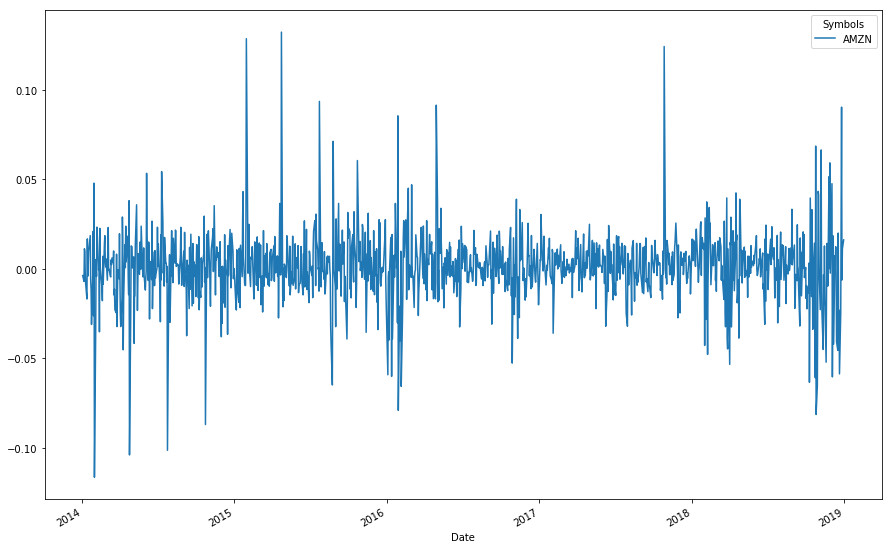

In [5]:
# Calcular a diferencia logarítmica de precios y graficarlos
Ret_AMZN_log = np.log(closes_AMZN/closes_AMZN.shift())
Ret_AMZN_log.plot(figsize=(15,10));

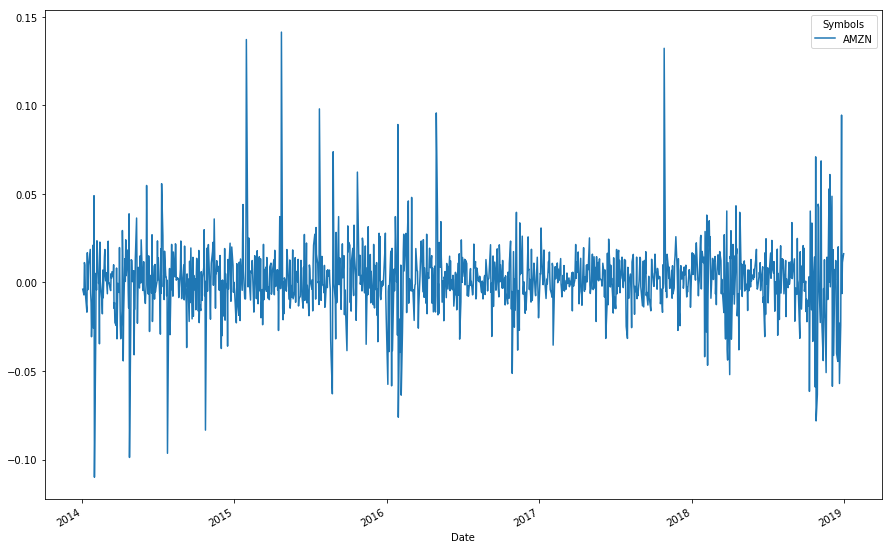

In [6]:
# Calcular rendimientos diarios y graficarlos
Ret_AMZN = (closes_AMZN - closes_AMZN.shift())/closes_AMZN.shift()
Ret_AMZN.plot(figsize=(15,10));

Entonces, suponemos que el cambio porcentual de los precios (rendimientos diarios) tiene una distribución normal.

¿Cómo se caracteriza una [distribución normal](https://es.wikipedia.org/wiki/Distribuci%C3%B3n_normal)?

In [7]:
# Calculamos media y desviación estándar
mu_AMZN = Ret_AMZN.mean()['AMZN']
sigma_AMZN = Ret_AMZN.std()['AMZN']

mu_AMZN,sigma_AMZN

(0.0012465588099914676, 0.01952381901991502)

Habiendo caracterizado los rendimientos diarios como una variable aleatoria normal con la media y la varianza muestral obtenida de los datos del 2018, podemos generar números aleatorios con estas características para simular el comportamiento de los precios de cierre de las acciones en el 2019 (hay un supuesto de que las cosas no cambiarán fundamentalmente).

Sin embargo, cada simulación que hagamos nos conducirá a distintos resultados (los precios siguen evolucionando aleatoriamente). Entonces, lo que haremos es simular varios escenarios para así ver alguna tendencia y tomar decisiones.

Hagamos una una función que simule varios escenarios de rendimientos diarios y que devuelva un dataframe con esta simulación.

In [8]:
# Ayuda en la función np.random.randn
help(np.random.randn)

Help on built-in function randn:

randn(...) method of mtrand.RandomState instance
    randn(d0, d1, ..., dn)
    
    Return a sample (or samples) from the "standard normal" distribution.
    
    If positive, int_like or int-convertible arguments are provided,
    `randn` generates an array of shape ``(d0, d1, ..., dn)``, filled
    with random floats sampled from a univariate "normal" (Gaussian)
    distribution of mean 0 and variance 1 (if any of the :math:`d_i` are
    floats, they are first converted to integers by truncation). A single
    float randomly sampled from the distribution is returned if no
    argument is provided.
    
    This is a convenience function.  If you want an interface that takes a
    tuple as the first argument, use `numpy.random.standard_normal` instead.
    
    Parameters
    ----------
    d0, d1, ..., dn : int, optional
        The dimensions of the returned array, should be all positive.
        If no argument is given a single Python float is ret

In [9]:
# Función que simula varios escenarios de rendimientos diarios
def ret_sim(mu,sigma,ndays,nscen,start_date):
    dates = pd.date_range(start_date,periods=ndays)
    datos = sigma*np.random.randn(ndays,nscen) + mu
    return pd.DataFrame(data=datos,index=dates)

In [10]:
# Simulamos 100 escenarios para todo el 2019
ndays = 365
nscen = 100
start_date = "2019-01-01"

sim_ret_AMZN = ret_sim(mu_AMZN,sigma_AMZN,ndays,nscen,start_date)

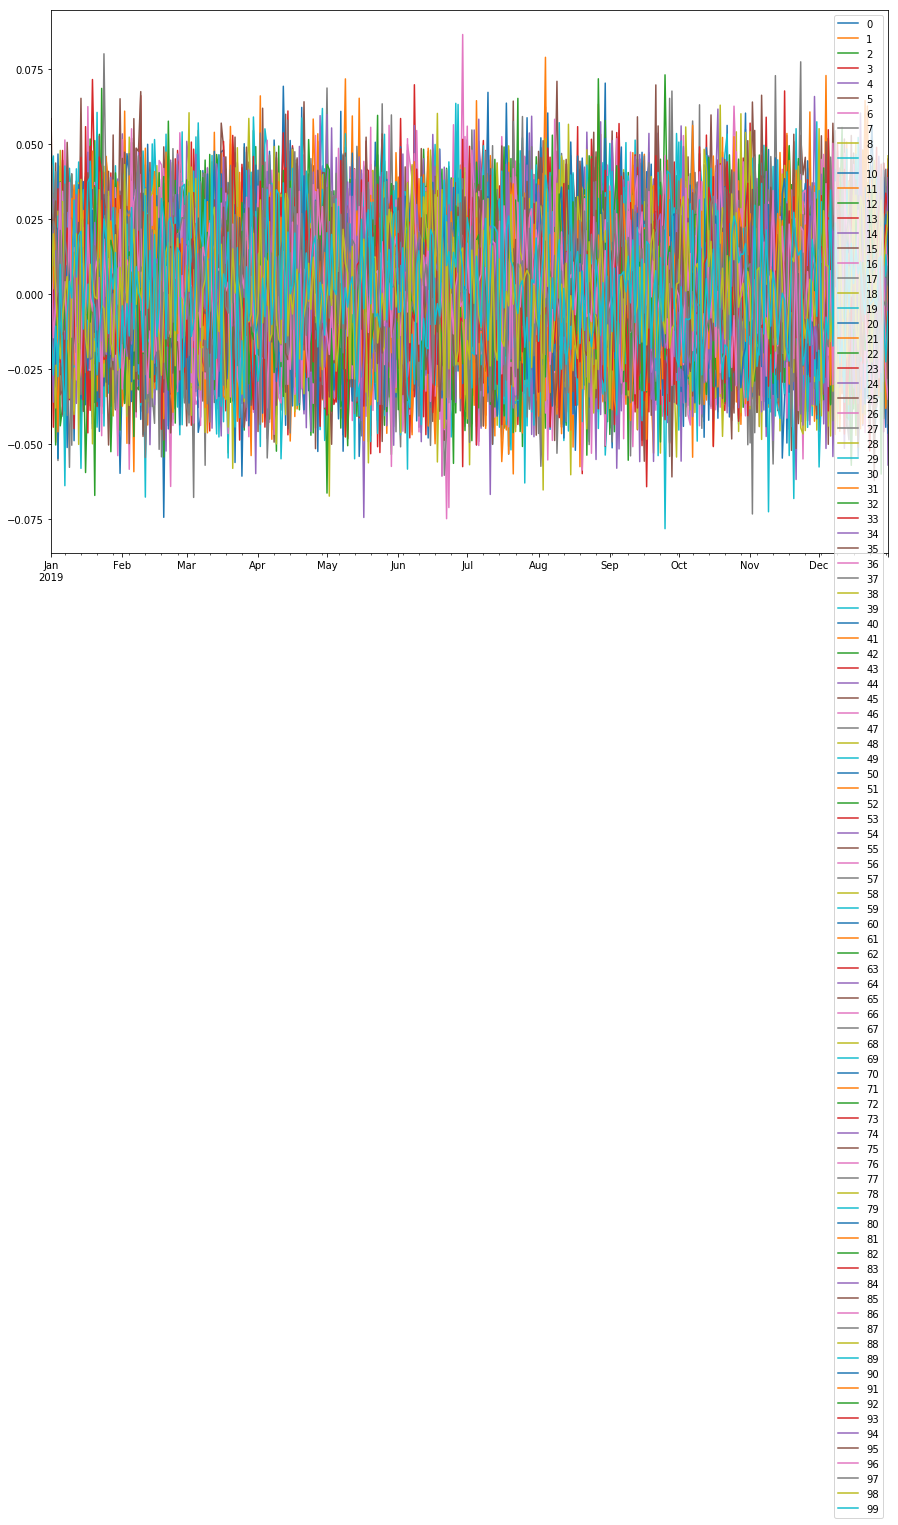

In [11]:
# Mostrar
sim_ret_AMZN.plot(figsize=(15,10))

## 3. Proyección de precios de cierre

Por tanto, para calcular los precios, tenemos:

$$\begin{align}
p_i&=p_{i-1}(R_i+1)\\
p_{i+1}&=p_i(R_{i+1}+1)=p_{i-1}(R_i+1)(R_{i+1}+1)\\
&\vdots\\
p_{i+k}&=p_{i-1}(R_i+1)\cdots(R_{i+k}+1).
\end{align}$$

Si hacemos $i=0$ en la última ecuación, tenemos que $p_{k}=p_{-1}(R_0+1)\cdots(R_{k}+1)$, donde $p_{-1}$ es el último precio reportado en el 2017.

Con los rendimientos, calculamos los precios de cierre...

In [12]:
# Obtenemos los precios. Transformar los rendimientos simulados del 2019 a precios de acción simulados del 2019.
sim_precios_closes_AMZN = closes_AMZN.iloc[-1]['AMZN']*((sim_ret_AMZN+1).cumprod())

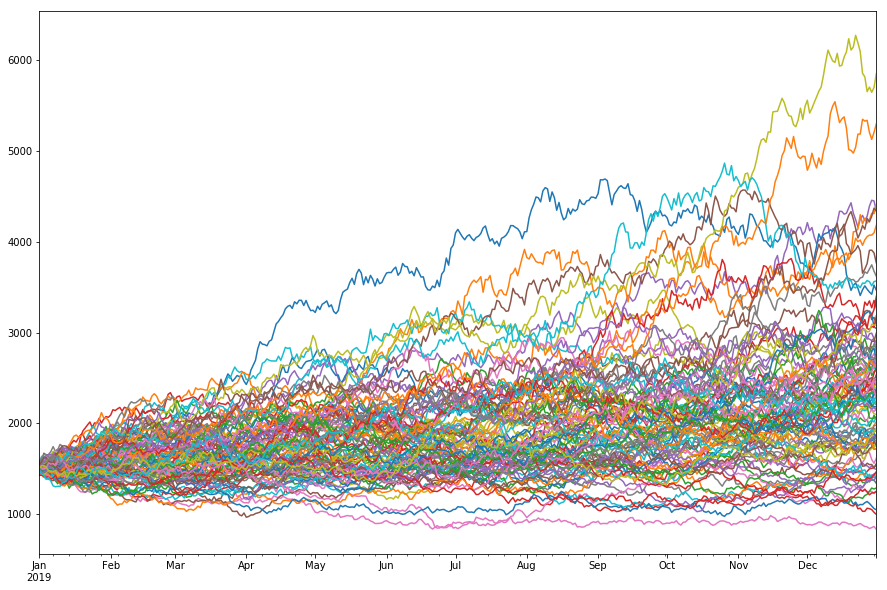

In [13]:
# Graficar
sim_precios_closes_AMZN.plot(figsize=(15,10),legend=False)

In [14]:
K = closes_AMZN.iloc[-1]['AMZN']*1.1
K

1652.1669677734376

## 4. Probabilidad Precio-Umbral

Ya que tenemos muchos escenarios de precios proyectados, podemos ver varias cosas. Por ejemplo, ¿cuál es la probabilidad de que el precio de cierre sobrepase algún valor umbral en algún momento?

In [15]:
# Umbral de 110% del ultimo precio
K = closes_AMZN.iloc[-1]['AMZN']*1.1

# Fechas
dates = sim_precios_closes_AMZN.index
K

1652.1669677734376

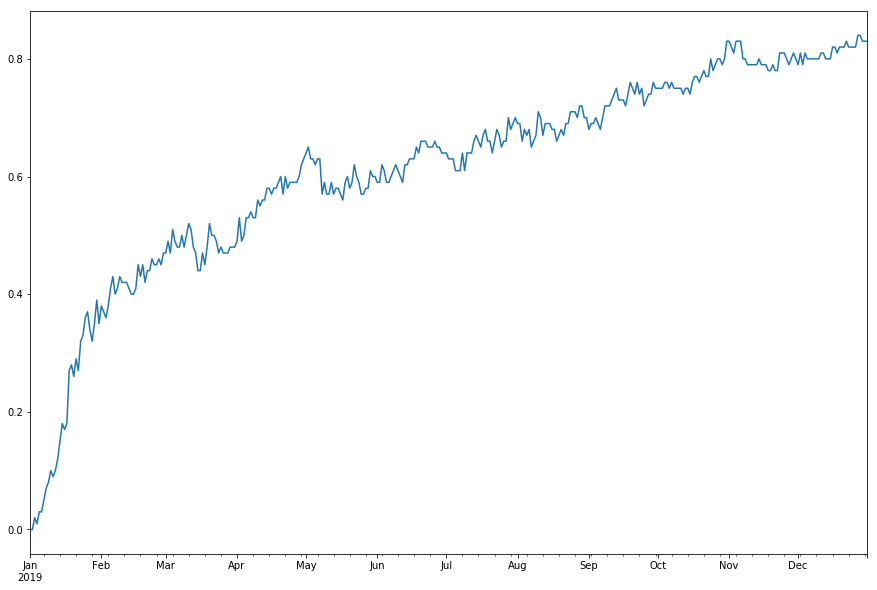

In [16]:
# Comparar cada escenario en cada fecha
TF = sim_precios_closes_AMZN >K

# Sumamos para cada fecha y dividimos entre el número de escenarios
prob = pd.DataFrame(TF.sum(axis=1)/nscen)

# Gráfico de probabilidad
prob.plot(figsize=(15,10),legend=False)

In [17]:
# Descargamos datos...
# Instrumento: Amazon
names = ["AMZN"]

# Fechas de interés (inicio y fin): 2014-2018
start = '2019-01-01'
end = '2019-12-31'

# Función DataReader
closes_AMZN_real = get_closes(names,start,end)

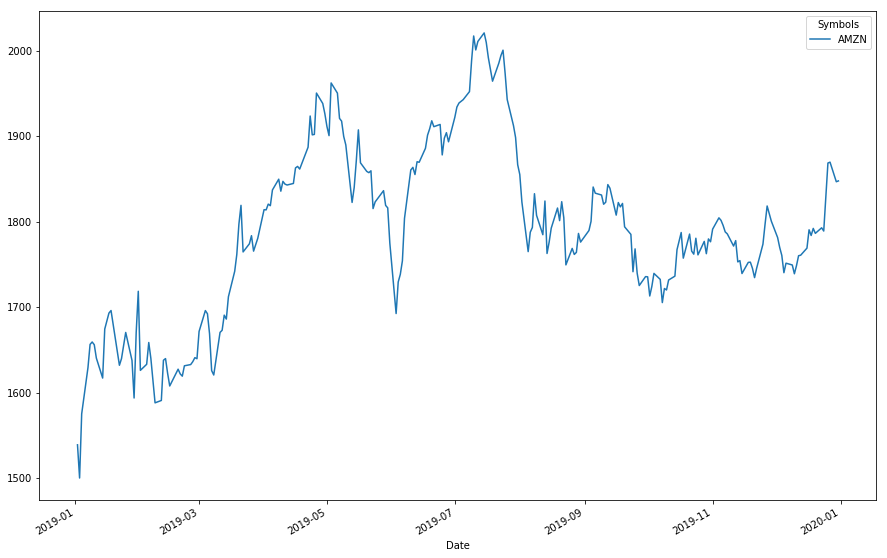

In [18]:
closes_AMZN_real.plot(figsize=(15,10))

___
Entonces, ya aprendimos a bajar datos con pandas-datareader. En específico, a partir de los precios de cierre ajustados obtuvimos los rendimientos diarios.

Suponiendo que los rendimientos diarios son un proceso estocástico estacionario de distribución normal, pudimos caracaterizarlo y proyectar varios escenarios de evolución de los precios (montecarlo).

Con estas proyecciones pudimos calcular probabilidades de sobrepasar cierto precio umbral: toma de decisiones.

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Cristian Camilo Zapata Zuluaga.
</footer>